# Quantiacs Toolbox Sample: Support Vector Machine(Momentum) 
This tutorial will show you how to use svm and momentum to predict the trend using the Quantiacs toolbox.  
We use the 20-day closing price momentum for the last week (5 days) as features and trend of the next day as value.  
For each prediction, we lookback one year (252 days).  

In [1]:
import quantiacsToolbox
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import svm
%matplotlib inline

In [2]:
%%html
<style>
table {float:left}
</style>

For developing and testing a strategy, we will use the raw data in the tickerData folder that has been downloaded via the Toolbox's loadData() function.
  
This is just a simple sample to show how svm works.  
Extract the closing price of the Australian Dollar future (F_AD) for the past year:

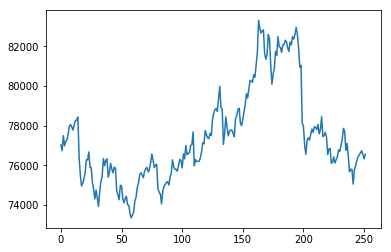

In [3]:
F_AD = pd.read_csv('./tickerData/F_AD.txt')
CLOSE = np.array(F_AD.loc[:252-1, [' CLOSE']])
plt.plot(CLOSE)

Momentum is generally defined as the return between two points in time separated by a fixed interval:  
**(p2-p1)/p1**  
Momentum is an indicator of the average speed of price on a time scale defined by the interval.  
The most used intervals by investors are 1, 3, 6 and 12 months, or their equivalent in trading days.  

Calculate 20-day momentum:

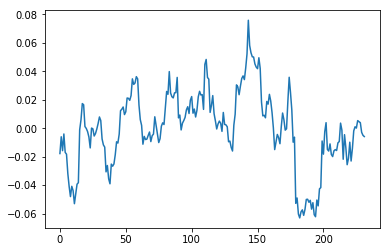

In [4]:
momentum = (CLOSE[20:] - CLOSE[:-20]) / CLOSE[:-20]
plt.plot(momentum)

## Now we can create samples.  
Use the last 5 days' momentum as features.  
We will use a binary trend: y = 1 if price goes up, y = -1 if price goes down  
  
For example, given close price, momentum at 19900114:  

| DATE | CLOSE | MOMENTUM |     
| :--- | ----- | -------- |
| 19900110 | 77580.0 | -0.01778759 |
| 19900111 | 77980.0 | -0.00599427 |
| 19900112 | 78050.0 | -0.01574397 |
| 19900113 | 77920.0 | -0.00402702 |
| 19900114 | 77770.0 | -0.01696891 |
| 19900115 | 78060.0 | -0.01824298 |

Corresponding sample should be  
x = (-0.01778759, -0.00599427, -0.01574397, -0.00402702, -0.01696891)  
y = 1  

In [5]:
X = np.concatenate([momentum[i:i+5] for i in range(252-20-5)], axis=1).T
y = np.sign((CLOSE[20+5:] - CLOSE[20+5-1: -1]).T[0])

#### Use svm learn and predict:

In [6]:
clf = svm.SVC()
clf.fit(X, y)
clf.predict(momentum[-5:].T)

array([ 1.])

#### 1 shows that the close price will go up tomorrow.  
#### What is the real result?

In [7]:
F_AD.loc[251:252, ['DATE', ' CLOSE']]

,DATE,CLOSE
251,19901228,76550.0
252,19901231,76560.0


#### Hooray! Our strategy successfully predict the trend.  
#### Now we can use Quantiac's Toolbox to run our strategy.

In [8]:
class myStrategy(object):
    
    def myTradingSystem(self, DATE, OPEN, HIGH, LOW, CLOSE, VOL, OI, P, R, RINFO, exposure, equity, settings):

        def predict(momentum, CLOSE, lookback, gap, dimension):
            X = np.concatenate([momentum[i:i + dimension] for i in range(lookback - gap - dimension)], axis=1).T
            y = np.sign((CLOSE[dimension+gap:] - CLOSE[dimension+gap-1:-1]).T[0])
            y[y==0] = 1

            clf = svm.SVC()
            clf.fit(X, y)

            return clf.predict(momentum[-dimension:].T)

        nMarkets = len(settings['markets'])
        lookback = settings['lookback']
        dimension = settings['dimension']
        gap = settings['gap']

        pos = np.zeros((1, nMarkets), dtype=np.float)

        momentum = (CLOSE[gap:, :] - CLOSE[:-gap, :]) / CLOSE[:-gap, :]

        for market in range(nMarkets):
            try:
                pos[0, market] = predict(momentum[:, market].reshape(-1, 1),
                                         CLOSE[:, market].reshape(-1, 1),
                                         lookback,
                                         gap,
                                         dimension)
            except ValueError:
                pos[0, market] = .0
        return pos, settings


    def mySettings(self):
        """ Define your trading system settings here """

        settings = {}

        # Futures Contracts
        settings['markets'] = ['CASH', 'F_AD', 'F_BO', 'F_BP', 'F_C', 'F_CC', 'F_CD',
                               'F_CL', 'F_CT', 'F_DX', 'F_EC', 'F_ED', 'F_ES', 'F_FC', 'F_FV', 'F_GC',
                               'F_HG', 'F_HO', 'F_JY', 'F_KC', 'F_LB', 'F_LC', 'F_LN', 'F_MD', 'F_MP',
                               'F_NG', 'F_NQ', 'F_NR', 'F_O', 'F_OJ', 'F_PA', 'F_PL', 'F_RB', 'F_RU',
                               'F_S', 'F_SB', 'F_SF', 'F_SI', 'F_SM', 'F_TU', 'F_TY', 'F_US', 'F_W', 'F_XX',
                               'F_YM']

        settings['lookback'] = 252
        settings['budget'] = 10 ** 6
        settings['slippage'] = 0.05

        settings['gap'] = 20
        settings['dimension'] = 5

        return settings

Loading Data...
Done! 
Evaluating Trading System


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/quantiacsToolbox/quantiacsToolbox.py:428: RuntimeWarning: invalid value encountered in divide
  position = position/np.sum(abs(position))


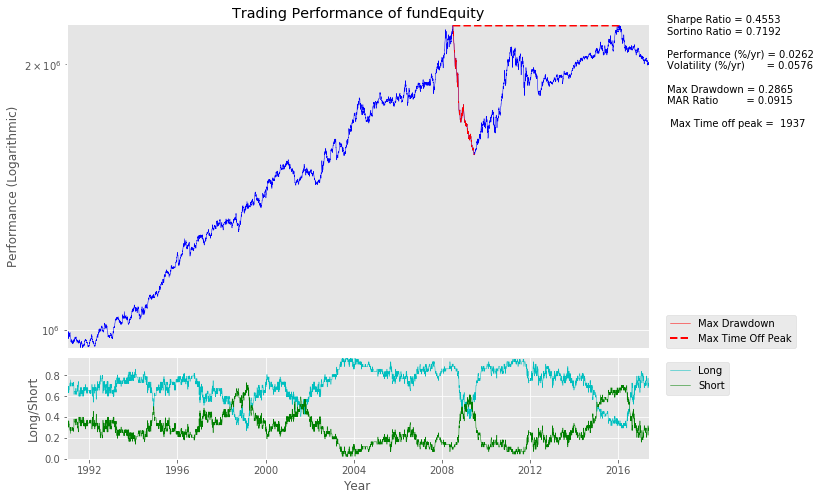

In [9]:
result = quantiacsToolbox.runts(myStrategy)

** Congrats! You just finished your first svm(momentum) strategy.**  

Try to optimize it!  

**Quantiacs https://www.quantiacs.com/**